Code submission for Deliverable 2 of MAIS 202 Final Project about artist identification, based on CNN model proposed in [5].

# Data Preprocessing

In [0]:
### Import libraries
import pandas as pd
import numpy as np
import matplotlib as plt
import os        

os.getcwd()

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [0]:
# Run this cell and select the kaggle.json file downloaded
# from the Kaggle account settings page.
from google.colab import files
files.upload()

In [3]:
# Let's make sure the kaggle.json file is present.
!ls -lha kaggle.json

-rw-r--r-- 1 root root 66 Nov 24 03:59 kaggle.json


In [0]:
# Next, install the Kaggle API client.
!pip install -q kaggle

In [0]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
# Copy the paintings dataset locally.
!kaggle datasets download -d ikarus777/best-artworks-of-all-time

 99% 2.27G/2.29G [00:43<00:00, 30.2MB/s]
100% 2.29G/2.29G [00:43<00:00, 56.1MB/s]


In [0]:
# Unzip the dataset
!unzip \best-artworks-of-all-time.zip
#!unzip \images.zip
#!unzip \resized.zip

In [8]:
# Verify that all files are present.
!ls

artists.csv		       images	    resized
best-artworks-of-all-time.zip  kaggle.json  sample_data


In [9]:
# Look into file artists.csv.
artists = pd.read_csv('artists.csv')
print("Shape of artists.csv: ", artists.shape)
artists.head()

Shape of artists.csv:  (50, 8)


,id,name,years,genre,nationality,bio,wikipedia,paintings
0,0,Amedeo Modigliani,1884 - 1920,Expressionism,Italian,Amedeo Clemente Modigliani (Italian pronunciat...,http://en.wikipedia.org/wiki/Amedeo_Modigliani,193
1,1,Vasiliy Kandinskiy,1866 - 1944,"Expressionism,Abstractionism",Russian,Wassily Wassilyevich Kandinsky (Russian: Васи́...,http://en.wikipedia.org/wiki/Wassily_Kandinsky,88
2,2,Diego Rivera,1886 - 1957,"Social Realism,Muralism",Mexican,Diego María de la Concepción Juan Nepomuceno E...,http://en.wikipedia.org/wiki/Diego_Rivera,70
3,3,Claude Monet,1840 - 1926,Impressionism,French,Oscar-Claude Monet (; French: [klod mɔnɛ]; 14 ...,http://en.wikipedia.org/wiki/Claude_Monet,73
4,4,Rene Magritte,1898 - 1967,"Surrealism,Impressionism",Belgian,René François Ghislain Magritte (French: [ʁəne...,http://en.wikipedia.org/wiki/René_Magritte,194


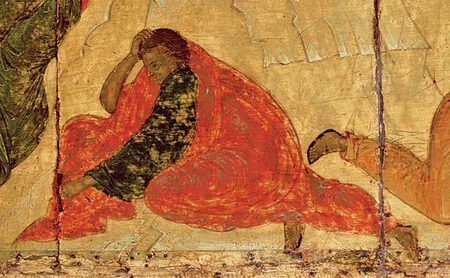

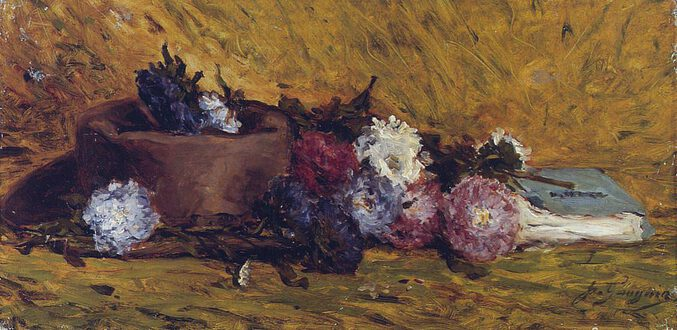

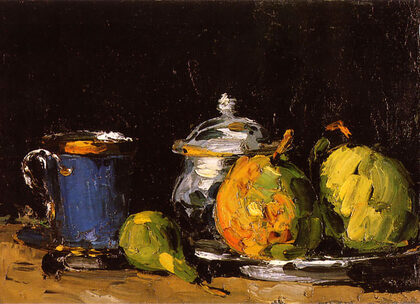

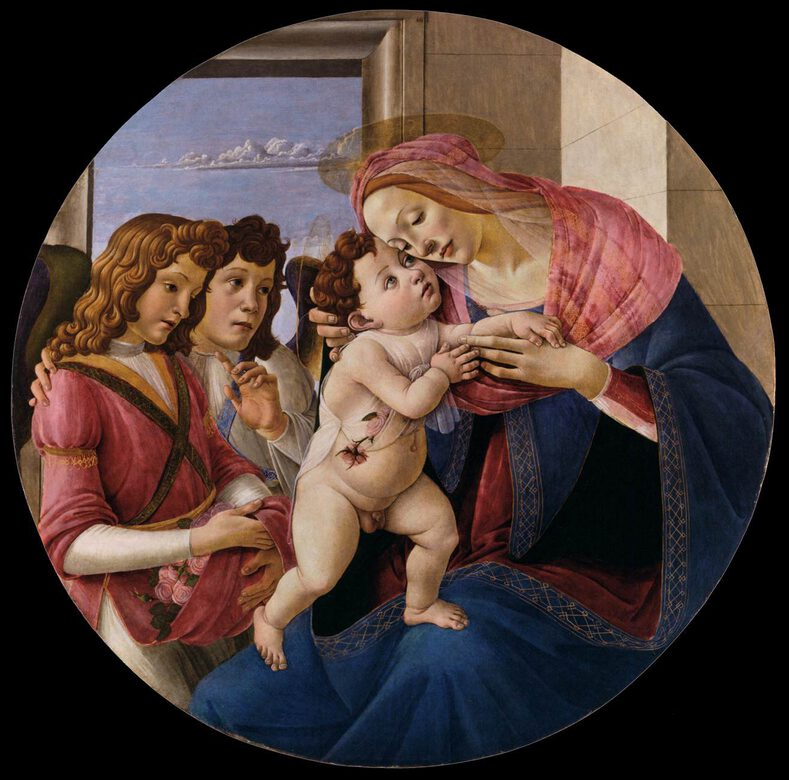

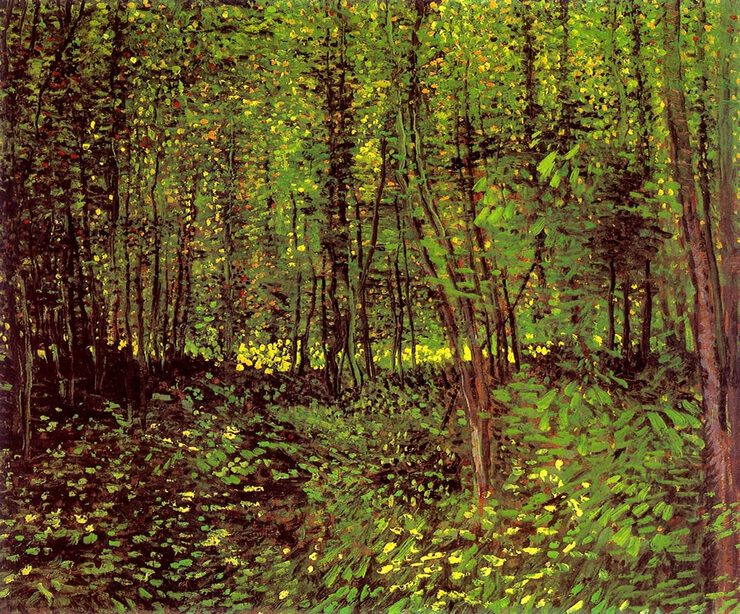

In [10]:
import glob
import matplotlib.pyplot as plt
from IPython.display import display, Image

# Display the first few images from the dataset. 
sample_images = glob.glob('resized/resized/*.jpg')[:5]
for file_path in sample_images:
  display(Image(file_path))

In [11]:
# Only take artists with more than 330 paintings.
artists = artists.sort_values(by=['paintings'], ascending=False)
top_artists = artists[artists['paintings'] >= 330].reset_index()
top_artists = top_artists[['name', 'paintings']]

# Define class weights, such that underrepresented classes will have higher weights.
nb_artists = top_artists.shape[0]
top_artists['class_weight'] = top_artists.paintings.sum() / (nb_artists * top_artists.paintings)

top_artists

,name,paintings,class_weight
0,Vincent van Gogh,877,0.671038
1,Edgar Degas,702,0.838319
2,Pablo Picasso,439,1.340547
3,Pierre-Auguste Renoir,336,1.751488


In [12]:
top_artists_name = top_artists['name'].str.replace(' ', '_').values
print("Top artists:", top_artists_name)

Top artists: ['Vincent_van_Gogh' 'Edgar_Degas' 'Pablo_Picasso' 'Pierre-Auguste_Renoir']


In [0]:
!mkdir top_images
!mv /content/images/images/Vincent_van_Gogh /content/top_images
!mv /content/images/images/Edgar_Degas /content/top_images
!mv /content/images/images/Pablo_Picasso /content/top_images
!mv /content/images/images/Pierre-Auguste_Renoir /content/top_images

In [14]:
# Resize images and split train-test sets.
batch_size = 32
train_input_shape = (100, 100, 3)

train_datagen = ImageDataGenerator(validation_split=0.2,
                                   rescale=1./255.,
                                   rotation_range=45,
                                   width_shift_range=0.5,
                                   height_shift_range=0.5,
                                   shear_range=5,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                  )

train_generator = train_datagen.flow_from_directory(directory='/content/top_images/',
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="training",
                                                    shuffle=True
                                                   )

valid_generator = train_datagen.flow_from_directory(directory='/content/top_images/',
                                                    class_mode='categorical',
                                                    #classes=list(top_artists['name']),
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="validation",
                                                    shuffle=True
                                                   )

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
print("Total number of batches =", STEP_SIZE_TRAIN, "and", STEP_SIZE_VALID)

Found 1885 images belonging to 4 classes.
Found 469 images belonging to 4 classes.
Total number of batches = 58 and 14


# Machine Learning Model

In [0]:
# Load pre-trained model.
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=train_input_shape)

for layer in base_model.layers:
    layer.trainable = True

In [0]:
# Add layers at the end.
X = base_model.output
X = Flatten()(X)

X = Dense(512, kernel_initializer='he_uniform')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

X = Dense(16, kernel_initializer='he_uniform')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

output = Dense(nb_artists, activation='softmax')(X)

model = Model(inputs=base_model.input, outputs=output)

In [0]:
optimizer = Adam(lr=0.0001)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])

In [0]:
n_epoch = 40

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                              verbose=1, mode='auto')

In [0]:
class_weights = top_artists['class_weight'].to_dict()

class_weights

{0: 0.6710376282782212,
 1: 0.8383190883190883,
 2: 1.3405466970387243,
 3: 1.7514880952380953}

In [0]:
# Train the model.
history1 = model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                              epochs=n_epoch,
                              shuffle=True,
                              verbose=1,
                              callbacks=[reduce_lr],
                              use_multiprocessing=True,
                              workers=16,
                              class_weight=class_weights
                             )

Epoch 1/40
58/58 [==============================] - 64s 1s/step - loss: 1.1875 - acc: 0.5397 - val_loss: 2.3841 - val_acc: 0.1830
Epoch 2/40
58/58 [==============================] - 59s 1s/step - loss: 0.8087 - acc: 0.7107 - val_loss: 2.8425 - val_acc: 0.1830
Epoch 3/40
58/58 [==============================] - 60s 1s/step - loss: 0.8212 - acc: 0.6919 - val_loss: 2.4593 - val_acc: 0.1830
Epoch 4/40
58/58 [==============================] - 62s 1s/step - loss: 0.7573 - acc: 0.7318 - val_loss: 3.3114 - val_acc: 0.1875
Epoch 5/40
58/58 [==============================] - 62s 1s/step - loss: 0.6678 - acc: 0.7615 - val_loss: 3.0878 - val_acc: 0.1406
Epoch 6/40
58/58 [==============================] - 63s 1s/step - loss: 0.6421 - acc: 0.7771 - val_loss: 1.9138 - val_acc: 0.1429
Epoch 7/40
58/58 [==============================] - 65s 1s/step - loss: 0.6134 - acc: 0.7874 - val_loss: 1.8717 - val_acc: 0.3638
Epoch 8/40
58/58 [==============================] - 66s 1s/step - loss: 0.6065 - acc: 0.78

# Training Results


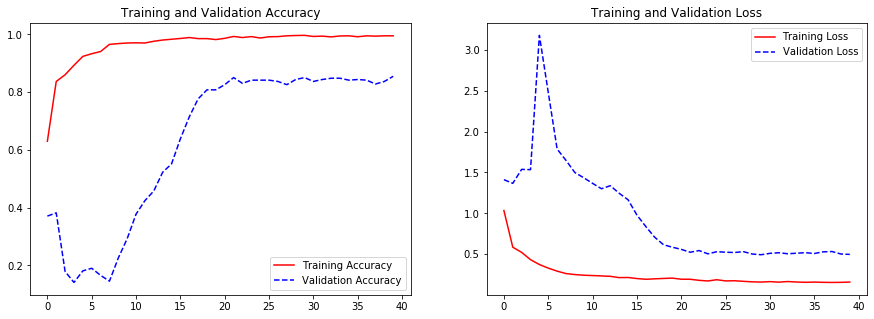

In [0]:
def plot_training(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    
    axes[0].plot(epochs, acc, 'r-', label='Training Accuracy')
    axes[0].plot(epochs, val_acc, 'b--', label='Validation Accuracy')
    axes[0].set_title('Training and Validation Accuracy')
    axes[0].legend(loc='best')

    axes[1].plot(epochs, loss, 'r-', label='Training Loss')
    axes[1].plot(epochs, val_loss, 'b--', label='Validation Loss')
    axes[1].set_title('Training and Validation Loss')
    axes[1].legend(loc='best')
    
    plt.show()
    
plot_training(history1)

In [0]:
# Prediction accuracy on train data
score = model.evaluate_generator(train_generator, verbose=1)
print("Prediction accuracy on train data =", score[1])

59/59 [==============================] - 33s 557ms/step - loss: 0.0994 - acc: 1.0000
Prediction accuracy on train data = 1.0


In [0]:
# Prediction accuracy on CV data
score = model.evaluate_generator(valid_generator, verbose=1)
print("Prediction accuracy on CV data =", score[1])

15/15 [==============================] - 8s 511ms/step - loss: 0.5273 - acc: 0.8230
Prediction accuracy on CV data = 0.82302773


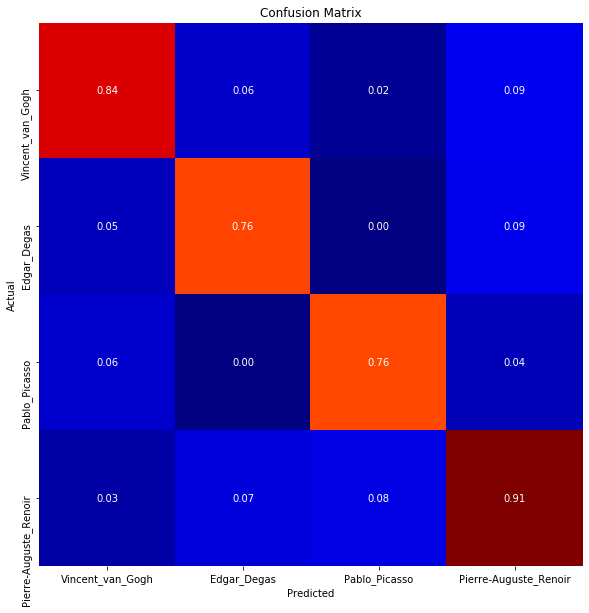

Classification Report:
                       precision    recall  f1-score   support

     Vincent_van_Gogh       0.86      0.84      0.85       128
          Edgar_Degas       0.85      0.76      0.81        84
        Pablo_Picasso       0.89      0.76      0.82        62
Pierre-Auguste_Renoir       0.80      0.91      0.85       163

             accuracy                           0.84       437
            macro avg       0.85      0.82      0.83       437
         weighted avg       0.84      0.84      0.84       437



In [0]:
# Classification report and confusion matrix
from sklearn.metrics import *
import seaborn as sns

tick_labels = top_artists_name
n_classes = 4

def showClassficationReport_Generator(model, valid_generator, STEP_SIZE_VALID):
    # Loop on each generator batch and predict
    y_pred, y_true = [], []
    for i in range(STEP_SIZE_VALID):
        (X,y) = next(valid_generator)
        y_pred.append(model.predict(X))
        y_true.append(y)
    
    # Create a flat list for y_true and y_pred
    y_pred = [subresult for result in y_pred for subresult in result]
    y_true = [subresult for result in y_true for subresult in result]
    
    # Update Truth vector based on argmax
    y_true = np.argmax(y_true, axis=1)
    y_true = np.asarray(y_true).ravel()
    
    # Update Prediction vector based on argmax
    y_pred = np.argmax(y_pred, axis=1)
    y_pred = np.asarray(y_pred).ravel()
    
    # Confusion Matrix
    fig, ax = plt.subplots(figsize=(10,10))
    conf_matrix = confusion_matrix(y_true, y_pred, labels=np.arange(n_classes))
    conf_matrix = conf_matrix/np.sum(conf_matrix, axis=1)
    sns.heatmap(conf_matrix, annot=True, fmt=".2f", square=True, cbar=False, 
                cmap=plt.cm.jet, xticklabels=tick_labels, yticklabels=tick_labels,
                ax=ax)
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    ax.set_ylim(n_classes, 0)
    ax.set_title('Confusion Matrix')
    plt.show()
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=np.arange(n_classes), target_names=top_artists_name))

showClassficationReport_Generator(model, valid_generator, STEP_SIZE_VALID)

In [0]:
# Authorizing access to Google Drive to save and download model.
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
!ls drive

In [0]:
# Save the trained model.
model.save("drive/model.h5")
print("Saved model to drive")

Saved model to drive


# References


1. *Best Artworks of All Time* database from [kaggle](https://www.kaggle.com/ikarus777/best-artworks-of-all-time)
2. *Art Challenge - A Quiz Game of Famous Painters* by [artchallenge.ru](https://artchallenge.ru)
3. Nitin Viswanathan, *Artist Identification with Convolutional Neural Networks*, Stanford University
4. Alexander Blessing and Kai Wen, *Using Machine Learning for Identification of Art Paintings*, Stanford University
5. Supratim Haldar, *DeepArtist : Identify Artist from Art* on [kaggle](https://www.kaggle.com/supratimhaldar/deepartist-identify-artist-from-art)